## Introduction

Gaussian Neural Networks are a class of probabilistic models that combine the flexibility of neural networks and delivers the results of gaussian processes. Here, we use gaussian neural networks and data from 2017 - 2019, 2021- 2023 (no covid) to predict the evictions for the 2024 data. We then will use the results to compare with the actual data and analyze.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

# sklearn stuff
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda import Moran_Local
from esda.getisord import G_Local
from shapely.geometry import Point
from libpysal.weights import Queen, Rook

# neural net stuff
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
# gdf already cleaned
file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'

In [6]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [7]:
evictions_cleaned = evictions_cleaned_raw.copy()

In [8]:
evictions_cleaned.head()

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,bin,bbl,nta,geometry,eviction_count,year,average_year_eviction_count,cluster,cluster_k,same_cluster
0,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,...,3143881.0,3.057940e+09,Sunset Park East,POINT (-74.011883 40.635941),3,2024,3.000000,0,0,True
1,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,40.640008,...,3143435.0,3.057820e+09,Sunset Park West,POINT (-74.017068 40.640008),3,2024,3.000000,0,0,True
2,*53336/16,170279,3400 PAUL AVENUE,15D,2018-10-17,BRONX,10468,Not an Ejectment,Possession,40.877190,...,2015444.0,2.032510e+09,Van Cortlandt Village,POINT (-73.889569 40.87719),4,2018,4.000000,0,0,True
3,*5990/17,2703,480 CONCORD AVENUE,4E,2019-08-30,BRONX,10455,Not an Ejectment,Possession,40.811197,...,2003900.0,2.025770e+09,Mott Haven-Port Morris,POINT (-73.90881 40.811197),9,2019,2.250000,0,0,True
4,000098/17,69483,65 EAST 193RD ST,1B,2017-05-04,BRONX,10468,Not an Ejectment,Possession,40.866075,...,2013945.0,2.031770e+09,Bedford Park-Fordham North,POINT (-73.896515 40.866075),8,2017,2.666667,0,0,True


In [9]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster'],
      dtype='object')

In [10]:
evictions_cleaned.shape

(76484, 24)

# Part 1:

- drop all the nans in the original dataset
- get training and testing dataset based on the year
- get X and y dataset for both training and testing (select the columns and the y)


In [18]:
# remove rows with nan values in the features
df_clean = evictions_cleaned.dropna(subset=['latitude', 'longitude', 'community_board',
                             'council_district', 'census_tract',
                             'eviction_count', 'average_year_eviction_count',
                             'cluster', 'cluster_k', 'borough'])
training_set = df_clean[
    (df_clean['year'].between(2017, 2019)) | (df_clean['year'].between(2021, 2023))
]
testing_set = df_clean[df_clean['year'] == 2024]

In [19]:
# recreate X_train and y_train from the cleaned training_set
X_data = training_set[['latitude', 'longitude', 'community_board',
                    'council_district', 'census_tract', 'cluster', 'cluster_k']].values
y_data = training_set['average_year_eviction_count'].values

In [22]:
print(training_set.shape), \
print(testing_set.shape), \
print(training_set.shape), \
print(df_clean.shape)

(64188, 24)
(9592, 24)
(64188, 24)
(76484, 24)


(None, None, None, None)

In [42]:
# recreate X_test and y_test from the cleaned training_set
X_data_test = testing_set[['latitude', 'longitude', 'community_board',
                    'council_district', 'census_tract', 'cluster', 'cluster_k']].values
y_data_test = testing_set['average_year_eviction_count'].values

# Part 2:
- process the test and train dataset, aka scale
- transform the data
- convert to tensors

In [30]:
scaler = StandardScaler()
scaler.fit(X_data)  # Fit the scaler to the data
X_data_scaled = scaler.transform(X_data)

In [43]:
scaler = StandardScaler()
scaler.fit(X_data_test)  # Fit the scaler to the data
X_data_test_scaled = scaler.transform(X_data_test)

In [35]:
# convert to PyTorch tensors
X_train = torch.tensor(X_data_scaled, dtype=torch.float32)
y_train = torch.tensor(y_data, dtype=torch.float32)
X_train.shape,\
y_train.shape

(torch.Size([64188, 7]), torch.Size([64188]))

In [44]:
# convert to PyTorch tensors
X_test = torch.tensor(X_data_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_data_test, dtype=torch.float32)
X_test.shape,\
y_test.shape

(torch.Size([9592, 7]), torch.Size([9592]))

# Part 3:

- define a simple GMNN
- define hyperparameters
- define gmnn loss
- train the model
- evaluate the model using test data
- get the results, mu, sigma, weights

In [33]:
class GMNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_components):
        # inherit GMNN to do the work
        super(GMNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        # means
        self.output_mu = nn.Linear(hidden_dim, n_components)
        # standard deviations
        self.output_sigma = nn.Linear(hidden_dim, n_components)
        # weights
        self.output_weights = nn.Linear(hidden_dim, n_components)

    def forward(self, x):
        hidden = torch.relu(self.hidden(x))
        mu = self.output_mu(hidden)
        sigma = torch.exp(self.output_sigma(hidden))
        weights = torch.softmax(self.output_weights(hidden), dim=1)
        return mu, sigma, weights

In [37]:
input_dim = X_train.shape[1]
hidden_dim = 64
# number of gaussian components
n_components = 3
model = GMNN(input_dim, hidden_dim, n_components)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
# negative log-likelihood or NLL
# parameters of the GMM
# source: https://www.probabilitycourse.com/chapter4/4_2_3_normal.php
# source: https://mpatacchiola.github.io/blog/2020/07/31/gaussian-mixture-models.html
# another source: https://shuaili8.github.io/Teaching/VE445/L12_gmm.pdf

def gmnn_loss(mu, sigma, weights, y):
    # avoid division by zero
    sigma = torch.clamp(sigma, min=1e-6)
    gaussian_pdf = (1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi, dtype=torch.float32)))) * \
                   torch.exp(-0.5 * ((y.unsqueeze(1) - mu) / sigma) ** 2)
    gaussian_pdf = torch.clamp(gaussian_pdf, min=1e-6)
    mixture_pdf = torch.sum(weights * gaussian_pdf, dim=1)
    mixture_pdf = torch.clamp(mixture_pdf, min=1e-6)
    nll = -torch.log(mixture_pdf)
    return torch.mean(nll)

In [41]:
print(X_train.shape)
print(y_train.shape)

torch.Size([64188, 7])
torch.Size([64188])


In [40]:
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    mu, sigma, weights = model(X_train)
    loss = gmnn_loss(mu, sigma, weights, y_train)
    if torch.isnan(loss):
        print("nan detected")
        break
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 3.484530448913574
Epoch 2, Loss: 3.4074997901916504
Epoch 3, Loss: 3.332066774368286
Epoch 4, Loss: 3.258559465408325
Epoch 5, Loss: 3.1860668659210205
Epoch 6, Loss: 3.115483522415161
Epoch 7, Loss: 3.046973943710327
Epoch 8, Loss: 2.9801957607269287
Epoch 9, Loss: 2.915529727935791
Epoch 10, Loss: 2.8526313304901123
Epoch 11, Loss: 2.7915360927581787
Epoch 12, Loss: 2.732886791229248
Epoch 13, Loss: 2.6772611141204834
Epoch 14, Loss: 2.6251118183135986
Epoch 15, Loss: 2.5771117210388184
Epoch 16, Loss: 2.5330512523651123
Epoch 17, Loss: 2.4928805828094482
Epoch 18, Loss: 2.456329345703125
Epoch 19, Loss: 2.4221816062927246
Epoch 20, Loss: 2.3901329040527344
Epoch 21, Loss: 2.3595170974731445
Epoch 22, Loss: 2.330162763595581
Epoch 23, Loss: 2.301882743835449
Epoch 24, Loss: 2.2754745483398438
Epoch 25, Loss: 2.2509677410125732
Epoch 26, Loss: 2.2277109622955322
Epoch 27, Loss: 2.2049198150634766
Epoch 28, Loss: 2.1823203563690186
Epoch 29, Loss: 2.1606924533843994
Epoc

In [51]:
# evaluation
model.eval()
with torch.no_grad():
    mu, sigma, weights = model(X_test)
    test_loss = gmnn_loss(mu, sigma, weights, y_test)
    print(f"test Loss: {test_loss.item()}")

test Loss: 1.4988946914672852


In [55]:
mu
# the means of the gaussian components for each prediction
# can be interpreted as the predicted eviction risk scores.

tensor([[0.4804, 1.2788, 0.7865],
        [0.4929, 1.2855, 0.7818],
        [1.1137, 2.3832, 1.3021],
        ...,
        [1.0856, 2.2135, 1.2705],
        [1.0823, 2.2257, 1.2863],
        [0.9085, 1.9539, 1.1791]])

In [56]:
sigma
# standard deviations, indicating the uncertainty of each prediction

tensor([[1.8089, 0.8158, 1.0143],
        [1.8142, 0.8114, 1.0100],
        [2.2763, 0.7705, 0.8457],
        ...,
        [2.3802, 0.7027, 0.9804],
        [2.3980, 0.7030, 0.9946],
        [2.2027, 0.7559, 1.1013]])

In [58]:
weights
# the mixing coefficients of the Gaussian components
# show the relative importance of each gaussian distribution

tensor([[0.1032, 0.8329, 0.0639],
        [0.1040, 0.8328, 0.0631],
        [0.0449, 0.9450, 0.0101],
        ...,
        [0.0554, 0.9310, 0.0136],
        [0.0532, 0.9339, 0.0129],
        [0.0638, 0.9156, 0.0205]])

# Part 4:

- add expected risk scores back to the testing dataset
- see the distribution
- see it on the map with expected reuslts
- compare the results with the actual 2024 data (data-wise and graph-wise) (TODO)

In [60]:
# the expected eviction risk score for each sample
expected_risk_scores = torch.sum(weights * mu, dim=1).numpy()
expected_risk_scores

array([1.1650047, 1.1711926, 2.3153794, ..., 2.1382544, 2.1527455,
       1.8713048], dtype=float32)

In [63]:
testing_set.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
       'same_cluster', 'expected_risk_score'],
      dtype='object')

In [69]:
# add a new column with data from expected risk scores
# then sort based on expected_risk_score
testing_set['expected_risk_score'] = expected_risk_scores
high_risk_areas = testing_set.sort_values(by='expected_risk_score', ascending=False)
high_risk_areas[['bbl', 'nta', 'expected_risk_score']].head(20)

,bbl,nta,expected_risk_score
25495,2.028820e+09,University Heights-Morris Heights,7.619424
23824,2.028820e+09,University Heights-Morris Heights,7.619424
24103,2.028820e+09,University Heights-Morris Heights,7.619148
24864,2.028820e+09,University Heights-Morris Heights,7.618232
32019,2.028820e+09,University Heights-Morris Heights,7.618232
25840,2.028820e+09,University Heights-Morris Heights,7.618232
29405,2.028820e+09,University Heights-Morris Heights,7.618232
22989,2.028820e+09,University Heights-Morris Heights,7.618232
32020,2.028820e+09,University Heights-Morris Heights,7.618232
26351,2.028820e+09,University Heights-Morris Heights,7.618232


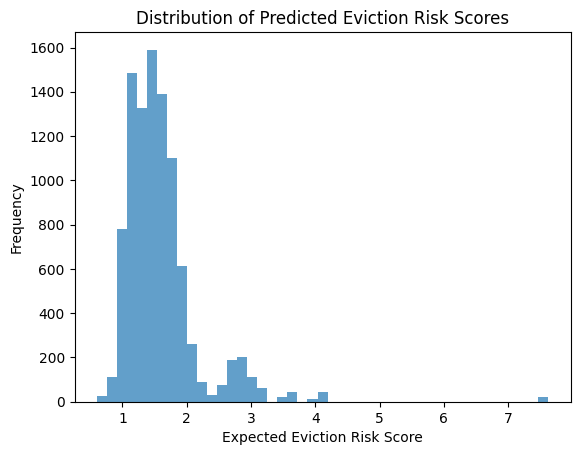

In [68]:
# to see the distribution
plt.hist(expected_risk_scores, bins=45, alpha=0.7)
plt.xlabel('Expected Eviction Risk Score')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Eviction Risk Scores')
plt.show()

In [66]:
# using folium
map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
for _, row in high_risk_areas.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        # if the expected_risk_score of the current row is greater than the 90th percentile of all risk scores, it is a high-risk area
        color='red' if row['expected_risk_score'] > np.percentile(expected_risk_scores, 90) else 'blue',
        fill=True
    ).add_to(map)

In [70]:
# map

Saving prediction.png to prediction.png


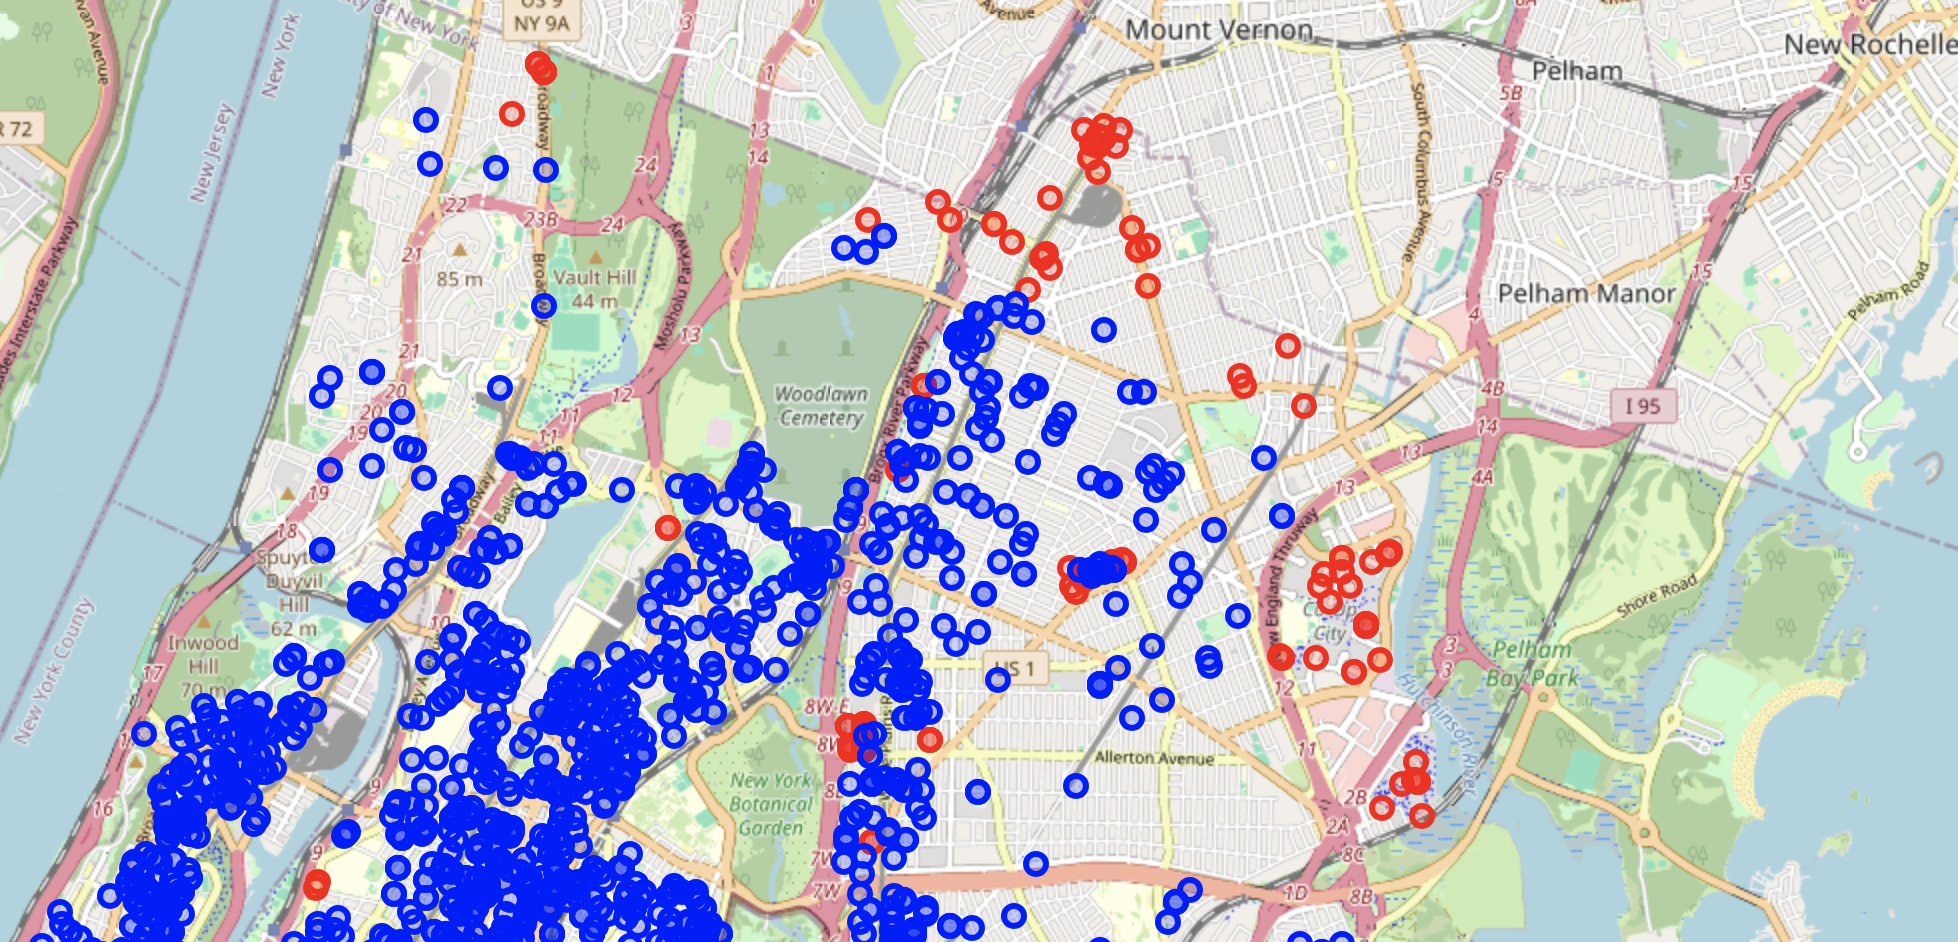

In [71]:
# one part of the map (too large)
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='prediction.png')

### What's next?

#### need to compare with 2024 data (TODO)